In [1]:
import time

start_time = time.time()

**Εγκατάσταση Java**

In [2]:
#Εγκατάσταση Java για να δουλέψει το Spark
!apt-get update
!apt-get install openjdk-17-jdk -y

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,149 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-securi

**Εκκίνηση Spark Session**

In [3]:
!pip -q install pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "4g").getOrCreate()
sc = spark.sparkContext
print("Spark Session Started")

Spark Session Started


**Ανάγνωση αρχείου**

In [4]:
# Διαβάστε το αρχείο flights_2000.csv σε ένα Spark DataFrame
flights_df = spark.read.csv('flights_2000.csv', header=True, inferSchema=True)

print("\nΣχήμα DataFrame:")
flights_df.printSchema()


Σχήμα DataFrame:
root
 |-- FL_DATE: date (nullable = true)
 |-- AIRLINE: string (nullable = true)
 |-- FL_NUM: integer (nullable = true)
 |-- ORIGIN_AIRPORT: string (nullable = true)
 |-- DEST_AIRPORT: string (nullable = true)
 |-- SCHED_DEP: timestamp (nullable = true)
 |-- DEP_DELAY: integer (nullable = true)
 |-- SCHED_ARR: timestamp (nullable = true)
 |-- ARR_DELAY: integer (nullable = true)
 |-- DIST_KM: integer (nullable = true)
 |-- CANCELLED: integer (nullable = true)



**Φιλτράρισμα/Υπολογισμός/Αποθήκευση Αποτελεσμάτων**

In [5]:
# Φιλτράρισμα των εγγραφών όπου CANCELLED = 0
filtered_df = flights_df.filter(flights_df.CANCELLED == 0)

# Αγνοήστε κενές ή μη αριθμητικές τιμές καθυστέρησης αναχώρησης
cleaned_df = filtered_df.na.drop(subset=["DEP_DELAY"])

# Υπολογισμός της μέσης καθυστέρησης αναχώρησης ανά διαδρομή
avg_delay_per_route = cleaned_df.groupBy("ORIGIN_AIRPORT", "DEST_AIRPORT").agg({"DEP_DELAY": "avg"})

# Ταξινόμηση για να βρούμε τις κορυφαίες 10 διαδρομές
top_10_avg_delay_per_route = avg_delay_per_route.orderBy("avg(DEP_DELAY)", ascending=False).limit(10)

# Εμφάνιση των 10 routes με τη μεγαλύτερη μέση καθυστέρηση
print("\nΟι 10 διαδρομές με τη μεγαλύτερη μέση καθυστέρηση αναχώρησης:")
action_start_time = time.time()
top_10_avg_delay_per_route.show()
action_end_time = time.time()

print(f"\nTime taken for the first Spark action (show()): {action_end_time - action_start_time:.2f} seconds")

# Αποθήκευση του DataFrame με τις κορυφαίες 10 διαδρομές σε αρχείο CSV
top_10_avg_delay_per_route.write.csv("/content/avg_delay_per_route.csv", header=True, mode="overwrite")

end_time = time.time()

total_time = end_time - start_time

print(f"Ο συνολικός χρόνος εκτέλεσης είναι: {total_time:.2f} δευτερόλεπτα")


Οι 10 διαδρομές με τη μεγαλύτερη μέση καθυστέρηση αναχώρησης:
+--------------+------------+------------------+
|ORIGIN_AIRPORT|DEST_AIRPORT|    avg(DEP_DELAY)|
+--------------+------------+------------------+
|           DFW|         JFK|              23.3|
|           JFK|         LAS|              22.8|
|           MIA|         JFK|              20.5|
|           MCO|         ORD|19.818181818181817|
|           MCO|         LAX|19.142857142857142|
|           BOS|         SEA|18.857142857142858|
|           DFW|         ATL|            18.625|
|           BOS|         PHX|18.181818181818183|
|           JFK|         MIA|              18.0|
|           DEN|         SFO|17.857142857142858|
+--------------+------------+------------------+


Time taken for the first Spark action (show()): 4.83 seconds
Ο συνολικός χρόνος εκτέλεσης είναι: 61.37 δευτερόλεπτα


**Pandas DataFrame (Θέμα 4)**

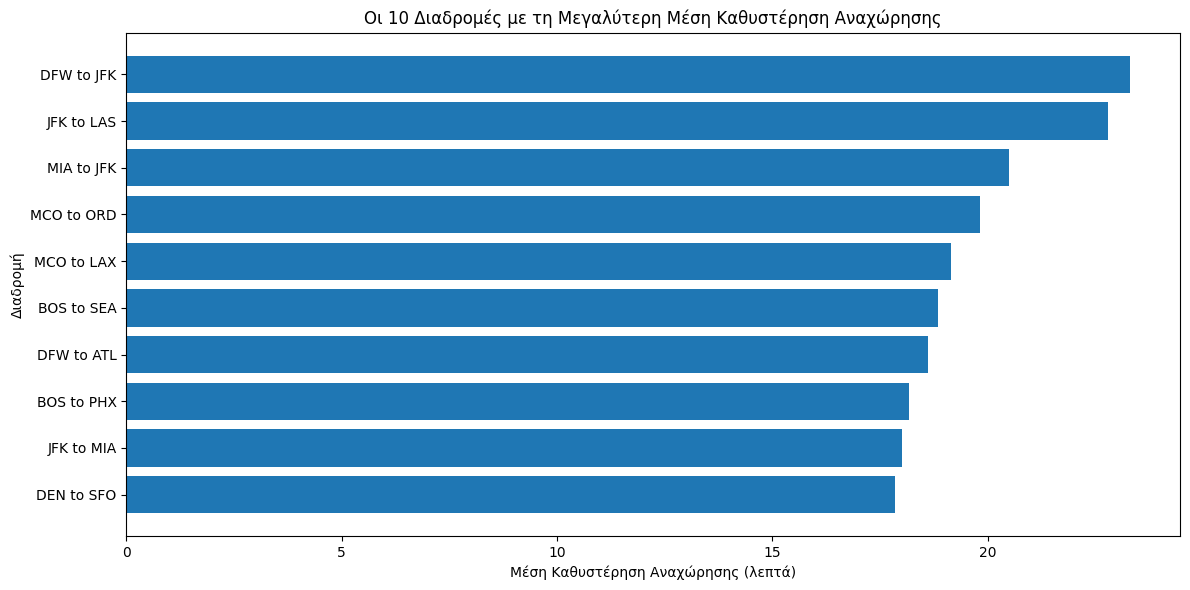

In [6]:
import matplotlib.pyplot as plt

#Μετατροπή τελικού DataFrame σε Pandas DataFrame
avg_delay_per_route_pd = avg_delay_per_route.toPandas()

# Ταξινόμηση του pandas DataFrame κατά μέση καθυστέρηση αναχώρησης
avg_delay_per_route_pd_sorted = avg_delay_per_route_pd.sort_values(by="avg(DEP_DELAY)", ascending=False)

# Επιλογή των κορυφαίων 10 διαδρομών για οπτικοποίηση
top_10_routes = avg_delay_per_route_pd_sorted.head(10)

# Δημιουργία γραφήματος
plt.figure(figsize=(12, 6))
plt.barh(top_10_routes["ORIGIN_AIRPORT"] + " to " + top_10_routes["DEST_AIRPORT"], top_10_routes["avg(DEP_DELAY)"])
plt.xlabel("Μέση Καθυστέρηση Αναχώρησης (λεπτά)")
plt.ylabel("Διαδρομή")
plt.title("Οι 10 Διαδρομές με τη Μεγαλύτερη Μέση Καθυστέρηση Αναχώρησης")
plt.gca().invert_yaxis() # Αντιστροφή του άξονα y για να εμφανιστεί η μεγαλύτερη καθυστέρηση στην κορυφή
plt.tight_layout()
plt.show()

**Θέμα 5**

**Μέση καθυστέρηση ανά ώρα αναχώρησης**


Μέση καθυστέρηση ανά ώρα αναχώρησης:
+----+------------------+
|HOUR|    avg(DEP_DELAY)|
+----+------------------+
|   5|               9.9|
|   6| 9.794642857142858|
|   7| 7.350877192982456|
|   8| 9.311926605504587|
|   9| 9.233009708737864|
|  10| 8.209090909090909|
|  11| 7.230769230769231|
|  12| 7.184873949579832|
|  13|  8.96078431372549|
|  14|              7.67|
|  15|  7.94392523364486|
|  16| 9.034782608695652|
|  17| 8.008333333333333|
|  18| 9.948717948717949|
|  19| 6.387596899224806|
|  20| 8.537037037037036|
|  21|12.732758620689655|
|  22| 5.989690721649485|
+----+------------------+



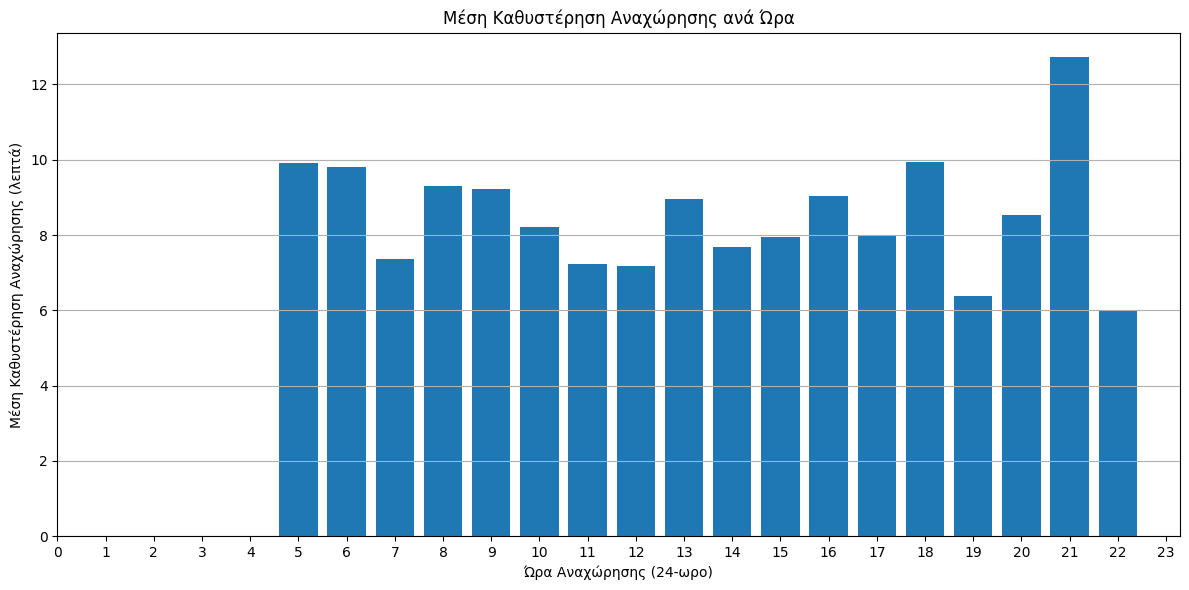

In [7]:
from pyspark.sql.functions import col

# Εξαγωγή της ώρας από το SCHED_DEP και cast σε integer
flights_df_with_hour = flights_df.withColumn("HOUR", (col("SCHED_DEP").substr(12, 2)).cast("int"))

# Φιλτράρισμα ακυρωμένων πτήσεων και πτήσεων χωρίς δεδομένα (null)
cleaned_flights_with_hour_df = flights_df_with_hour.filter(flights_df_with_hour.CANCELLED == 0).na.drop(subset=["DEP_DELAY"])

# Yπολογισμός μέσης καθυστέρησης ανά ώρα
avg_delay_per_hour = cleaned_flights_with_hour_df.groupBy("HOUR").agg({"DEP_DELAY": "avg"}).orderBy("HOUR")

print("\nΜέση καθυστέρηση ανά ώρα αναχώρησης:")
avg_delay_per_hour.show(24)

avg_delay_per_hour_pd = avg_delay_per_hour.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(avg_delay_per_hour_pd["HOUR"], avg_delay_per_hour_pd["avg(DEP_DELAY)"])
plt.xlabel("Ώρα Αναχώρησης (24-ωρο)")
plt.ylabel("Μέση Καθυστέρηση Αναχώρησης (λεπτά)")
plt.title("Μέση Καθυστέρηση Αναχώρησης ανά Ώρα")
plt.xticks(range(24))
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Κατανομή Καθυστερήσεων ανά Αεροπορική Εταιρεία**


Μέση καθυστέρηση ανά αεροπορική εταιρεία:
+-------+------------------+
|AIRLINE|    avg(DEP_DELAY)|
+-------+------------------+
|     WN|10.283898305084746|
|     DL| 9.528301886792454|
|     AS| 9.357446808510637|
|     F9| 8.109704641350211|
|     AA| 7.934497816593886|
|     B6| 7.894308943089431|
|     NK| 7.655038759689923|
|     UA| 7.600760456273764|
+-------+------------------+



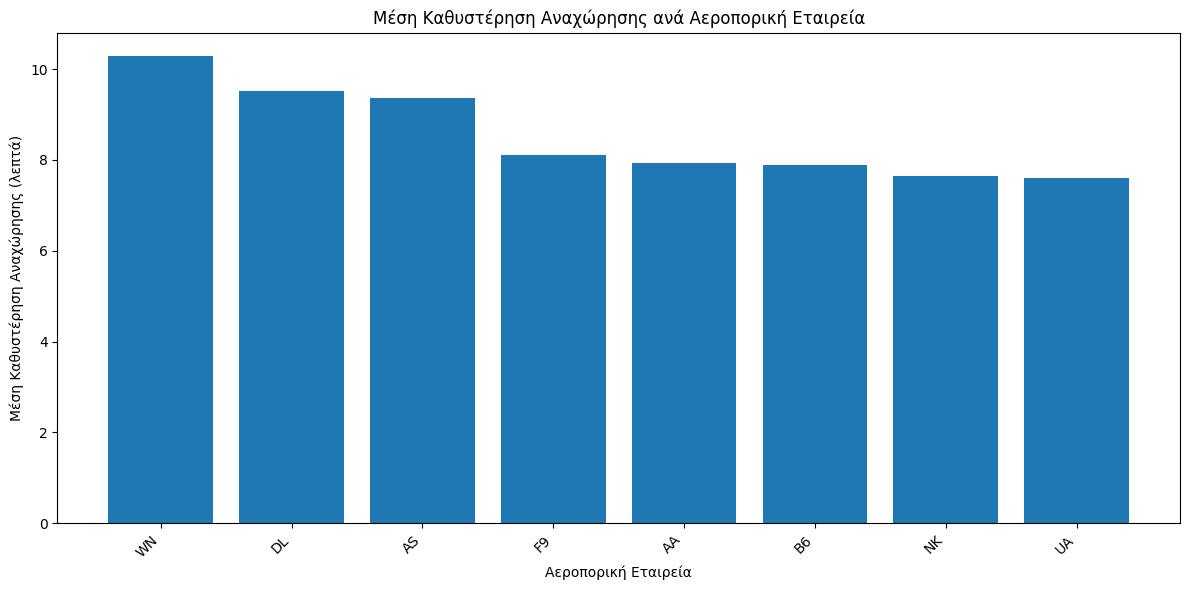

In [8]:
# Υπολογισμός μέσης καθυστέρησης ανά αεροπορική εταιρεία
avg_delay_per_airline = cleaned_df.groupBy("AIRLINE").agg({"DEP_DELAY": "avg"}).orderBy("avg(DEP_DELAY)", ascending=False)

print("\nΜέση καθυστέρηση ανά αεροπορική εταιρεία:")
avg_delay_per_airline.show()

avg_delay_per_airline_pd = avg_delay_per_airline.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(avg_delay_per_airline_pd["AIRLINE"], avg_delay_per_airline_pd["avg(DEP_DELAY)"])
plt.xlabel("Αεροπορική Εταιρεία")
plt.ylabel("Μέση Καθυστέρηση Αναχώρησης (λεπτά)")
plt.title("Μέση Καθυστέρηση Αναχώρησης ανά Αεροπορική Εταιρεία")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**Heatmap Καθυστερήσεων ανά Διαδρομή**

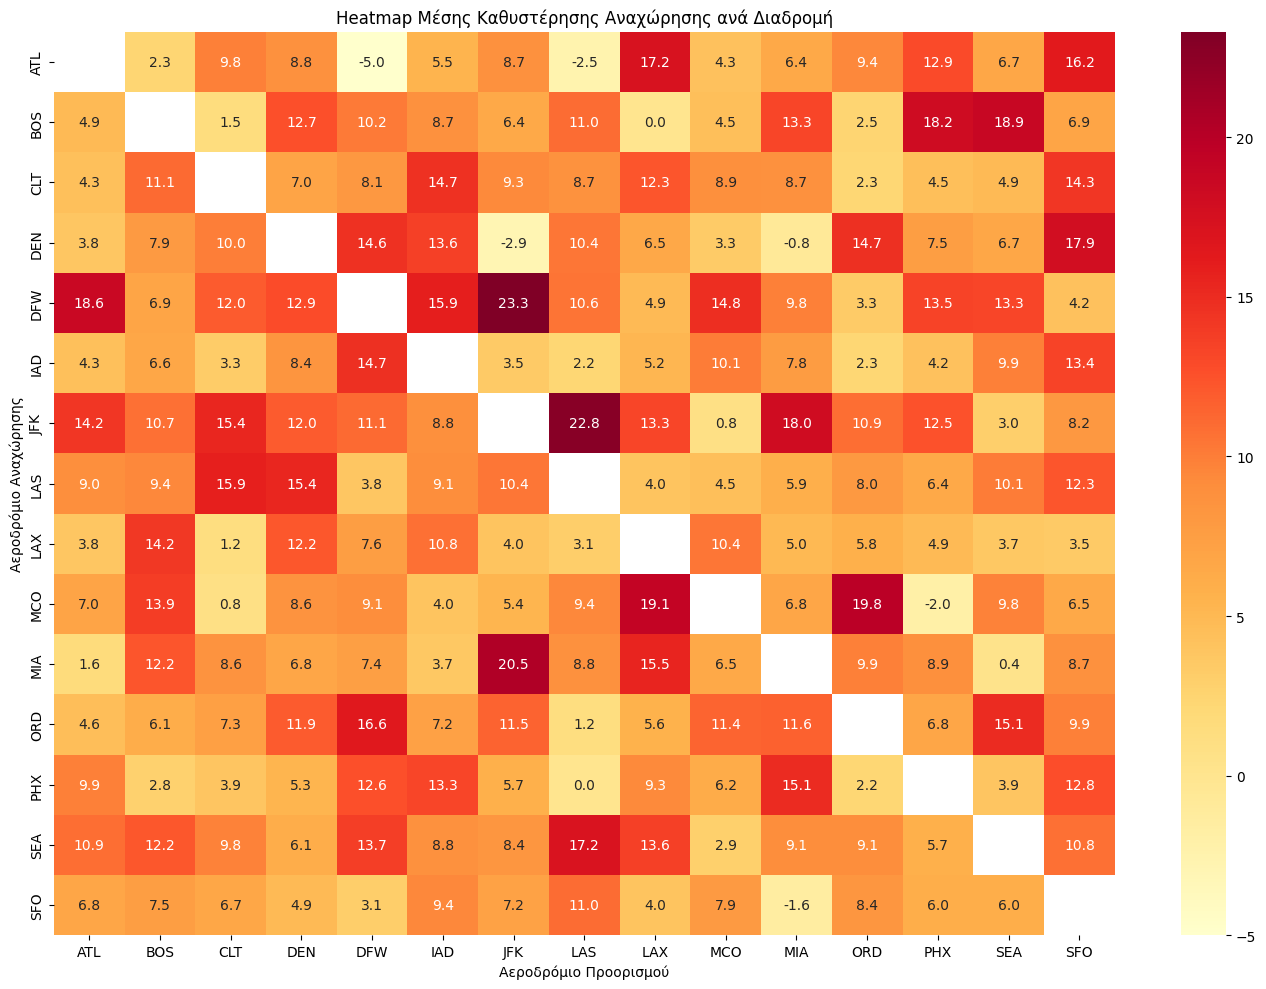

In [9]:
import seaborn as sns

heatmap_data = avg_delay_per_route_pd.pivot(index="ORIGIN_AIRPORT", columns="DEST_AIRPORT", values="avg(DEP_DELAY)")

plt.figure(figsize=(14, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd")
plt.xlabel("Αεροδρόμιο Προορισμού")
plt.ylabel("Αεροδρόμιο Αναχώρησης")
plt.title("Heatmap Μέσης Καθυστέρησης Αναχώρησης ανά Διαδρομή")
plt.tight_layout()
plt.show()